# Neural Network

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [25]:
%run preprocessing.ipynb


In [26]:
# Perform preprocessing

data = perform_preprocessing() # type: ignore
data['Type'].value_counts()

C:\Users\robof\AppData\Local\Temp\ipykernel_15072\2672841116.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(data[column_to_average].mean(axis=1), inplace=True)
C:\Users\robof\AppData\Local\Temp\ipykernel_15072\2672841116.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always be

Type
2    943
1    933
0    927
Name: count, dtype: int64

In [27]:
class NNModel(nn.Module):
    def __init__(self, seed, in_features=12, num_hidden_layers=4, out_categories=3):
        super(NNModel, self).__init__()
        self.num_hidden = num_hidden_layers
        hidden_layers = []
        for i in range(0,num_hidden_layers):
            hidden_layers.append(12)

        self.input = nn.Linear(in_features, hidden_layers[0])
        self.hidden_layers = nn.ModuleList()
        self.hidden_layers.append(nn.Linear(hidden_layers[0], hidden_layers[1]))
        for i in range(1, num_hidden_layers):
            self.hidden_layers.append(nn.Linear(hidden_layers[i - 1], hidden_layers[i]))
        self.output = nn.Linear(12, out_categories)

        np.random.seed(seed)
        torch.manual_seed(seed)
    def forward(self, x):
        x = F.relu(self.input(x))
        for hidden_layer in self.hidden_layers:
            x = F.relu(hidden_layer(x))
        x = F.relu(self.output(x))
        return x

# Training the model

In [28]:
momentum = 0.9
learning_rate = 0.05
epochs = 500
seed = round(time.time())
num_hidden_layers = 2
test_proportion = 0.15

## Split the data

In [29]:
X = data.drop(labels=['Type'], axis=1)
y = data['Type']


X = X.values
y = y.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_proportion, random_state = seed)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

## Train model

### Rprop

In [30]:
losses = []

def train_model(optimiser, criterion, epochs, classifier):
    losses = []
    for i in range(epochs):
        y_pred = classifier.forward(X_train)

        loss = criterion(y_pred, y_train)
        losses.append(loss.detach().numpy())

        if i % 100 == 0:
            print(f'Epoch: {i} and loss: {loss}')

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

    plt.plot(range(epochs), losses)
    plt.ylabel("loss/error")
    plt.xlabel("Epoch")

    # See the model's prediction accuracy using testing set
    with torch.no_grad():
        y_val = classifier.forward(X_train)
        loss = criterion(y_val, y_train)
        print(f'Loss: {loss}')

        correct = (torch.argmax(y_val, dim=1) == y_train).float()
        accuracy = correct.sum() / len(correct)
        print(f'Accuracy: {accuracy}')


    # Test the model with testing set after training model
    with torch.no_grad():
        y_val = classifier.forward(X_test)
        loss = criterion(y_val, y_test)
        print(f'Loss: {loss}')

        correct = (torch.argmax(y_val, dim=1) == y_test).float()
        accuracy = correct.sum() / len(correct)
        print(f'Accuracy: {accuracy}')

### Rprop

In [31]:
def RPROP_run():
  classifier = NNModel(seed=seed, num_hidden_layers=num_hidden_layers)

  criterion = nn.CrossEntropyLoss()
  optimiser = torch.optim.Rprop(classifier.parameters(), lr=learning_rate)

  train_model(optimiser, criterion, epochs, classifier)

### SGD


In [32]:
def SGD_run():
  classifier = NNModel(seed=seed, num_hidden_layers=num_hidden_layers)

  criterion = nn.CrossEntropyLoss()
  optimiser = torch.optim.SGD(classifier.parameters(), lr=learning_rate, momentum=momentum)

  train_model(optimiser, criterion, epochs, classifier)

Running for num_hidden_layers: 2 and learning_rate: 0.03
Running for num_hidden_layers: 2 and learning_rate: 0.06
Running for num_hidden_layers: 2 and learning_rate: 0.09
Running for num_hidden_layers: 2 and learning_rate: 0.12
Running for num_hidden_layers: 2 and learning_rate: 0.15
Running for num_hidden_layers: 2 and learning_rate: 0.18
Running for num_hidden_layers: 2 and learning_rate: 0.21
Running for num_hidden_layers: 4 and learning_rate: 0.03
Running for num_hidden_layers: 4 and learning_rate: 0.06
Running for num_hidden_layers: 4 and learning_rate: 0.09
Running for num_hidden_layers: 4 and learning_rate: 0.12
Running for num_hidden_layers: 4 and learning_rate: 0.15
Running for num_hidden_layers: 4 and learning_rate: 0.18
Running for num_hidden_layers: 4 and learning_rate: 0.21
Running for num_hidden_layers: 6 and learning_rate: 0.03
Running for num_hidden_layers: 6 and learning_rate: 0.06
Running for num_hidden_layers: 6 and learning_rate: 0.09
Running for num_hidden_layers: 

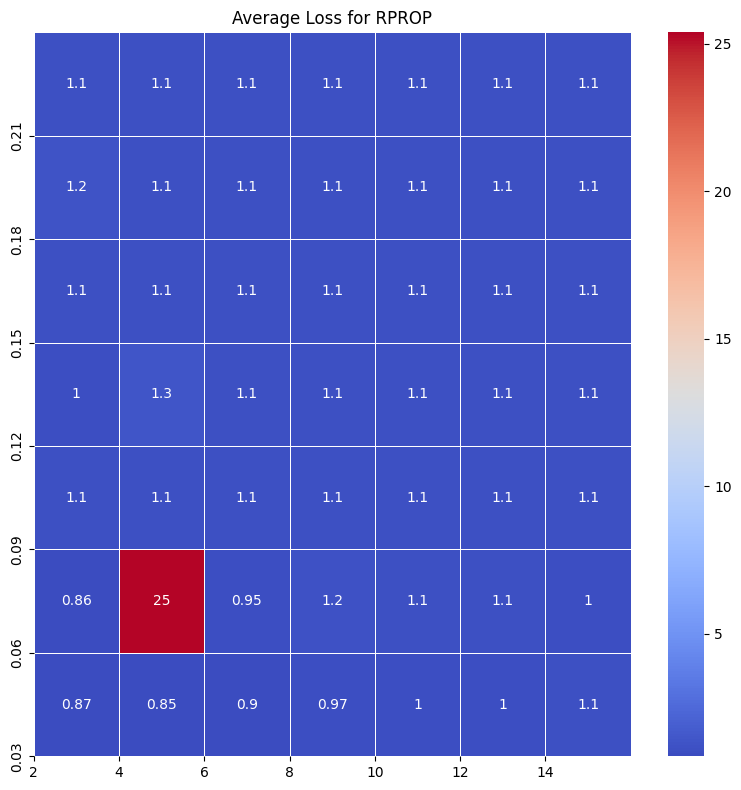

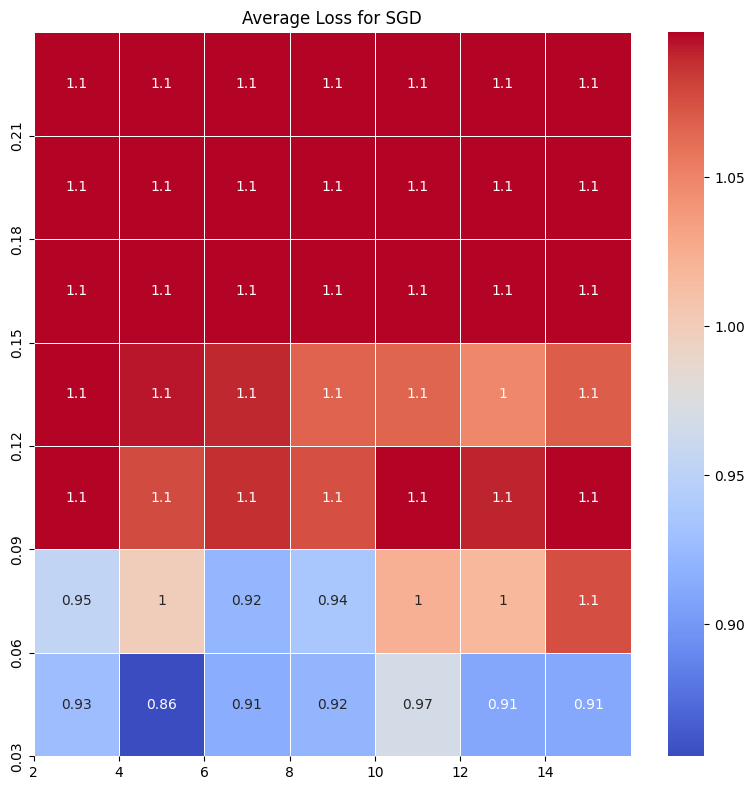

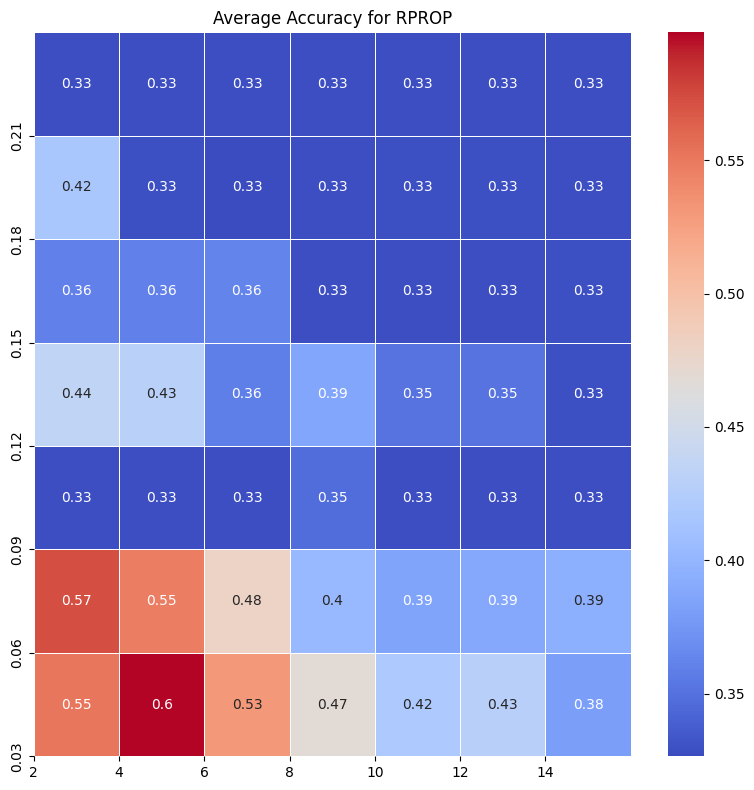

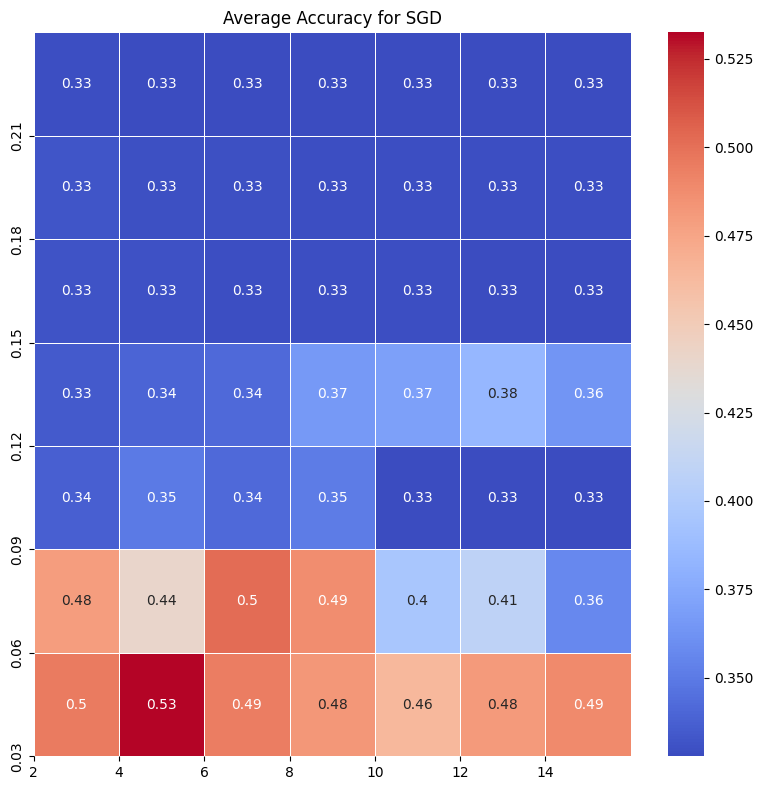

In [33]:
num_hidden_layers_array = [2, 4, 6, 8, 10, 12, 14]
learning_rates_array = [0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.21]

num_runs = 10

def run():
  finalLoss = np.zeros((len(num_hidden_layers_array), len(learning_rates_array)))
  finalLoss_2 = np.zeros((len(num_hidden_layers_array), len(learning_rates_array)))
  finalAccuracy = np.zeros((len(num_hidden_layers_array), len(learning_rates_array)))
  finalAccuracy_2 = np.zeros((len(num_hidden_layers_array), len(learning_rates_array)))

  for run in range(num_runs):
      seed = round(time.time())
      for i, num_hidden in enumerate(num_hidden_layers_array):
          for j, learning_rate in enumerate(learning_rates_array):
              print(f"Running for num_hidden_layers: {num_hidden} and learning_rate: {learning_rate}")
              classifier = NNModel(seed=seed, num_hidden_layers=num_hidden)
              classifier_2 = NNModel(seed=seed, num_hidden_layers=num_hidden) 

              criterion = nn.CrossEntropyLoss()
              criterion_2 = nn.CrossEntropyLoss()

              optimiser = torch.optim.Rprop(classifier.parameters(), lr=learning_rate)
              optimiser_2 = torch.optim.SGD(classifier_2.parameters(), lr=learning_rate, momentum=momentum)

              for epoch in range(epochs):
                  y_pred = classifier.forward(X_train)
                  y_pred_2 = classifier_2.forward(X_train)

                  loss = criterion(y_pred, y_train)
                  loss_2 = criterion_2(y_pred_2, y_train)

                  optimiser.zero_grad()
                  optimiser_2.zero_grad()
                  loss.backward()
                  loss_2.backward()
                  optimiser.step()
                  optimiser_2.step()

              with torch.no_grad():
                  y_val = classifier.forward(X_test)
                  y_val_2 = classifier_2.forward(X_test)

                  # Convert PyTorch tensors to scalars with .item() before adding to NumPy arrays
                  finalLoss[i, j] += criterion(y_val, y_test).item()
                  finalLoss_2[i, j] += criterion_2(y_val_2, y_test).item()

                  correct = (torch.argmax(y_val, dim=1) == y_test).float()
                  correct_2 = (torch.argmax(y_val_2, dim=1) == y_test).float()

                  finalAccuracy[i, j] += correct.sum().item() / len(correct)
                  finalAccuracy_2[i, j] += correct_2.sum().item() / len(correct_2)

  # Averaging across the runs
  finalLoss /= num_runs
  finalLoss_2 /= num_runs
  finalAccuracy /= num_runs
  finalAccuracy_2 /= num_runs

  return finalLoss, finalLoss_2, finalAccuracy, finalAccuracy_2


def create_heatmap(results, heading):
  plt.figure(figsize=(8, 8))
  sns.heatmap(results, annot=True, cmap='coolwarm', linewidths=0.5)
  plt.xticks(ticks=np.arange(len(num_hidden_layers_array)), labels=num_hidden_layers_array)
  plt.yticks(ticks=np.arange(len(learning_rates_array)), labels=learning_rates_array)
  plt.gca().invert_yaxis()
  plt.title(heading, fontsize=12)
  plt.tight_layout()
  plt.show()

averageLossResults, averageLossResults2, avergaeAccuracyResults, averageAccuracyResults2 = run()

create_heatmap(averageLossResults, "Average Loss for RPROP")
create_heatmap(averageLossResults2, "Average Loss for SGD")
create_heatmap(avergaeAccuracyResults, "Average Accuracy for RPROP")
create_heatmap(averageAccuracyResults2, "Average Accuracy for SGD")


# Hybrid learning

In [36]:
learning_rate_1 = 0.03
learning_rate_2 = 0.03

num_hidden_1 = 4
num_hidden_2 = 4

classifier = NNModel(seed=seed, num_hidden_layers=num_hidden_1)
classifier_2 = NNModel(seed=seed, num_hidden_layers=num_hidden_2) 

criterion = nn.CrossEntropyLoss()
criterion_2 = nn.CrossEntropyLoss()

optimiser = torch.optim.Rprop(classifier.parameters(), lr=learning_rate)
optimiser_2 = torch.optim.SGD(classifier_2.parameters(), lr=learning_rate, momentum=momentum)

for epoch in range(epochs):
    # Forward pass through both models
    y_pred = classifier.forward(X_train)
    y_pred_2 = classifier_2.forward(X_train)

    # Compute losses for both models
    loss = criterion(y_pred, y_train)
    loss_2 = criterion_2(y_pred_2, y_train)

    # Zero the gradients
    optimiser.zero_grad()
    optimiser_2.zero_grad()

    # Backward pass for both models (calculate gradients)
    loss.backward()
    loss_2.backward()

    # Get the gradients of each optimizer
    for param_classifier, param_classifier_2 in zip(classifier.parameters(), classifier_2.parameters()):
        if param_classifier.grad is not None and param_classifier_2.grad is not None:
            # Get the average of the gradients
            avg_grad = (param_classifier.grad + param_classifier_2.grad) / 2

            # Assign the averaged gradient to both classifiers
            param_classifier.grad.copy_(avg_grad)
            param_classifier_2.grad.copy_(avg_grad)

    # Perform the parameter updates using the averaged gradients
    optimiser.step()
    optimiser_2.step()


# See the model's prediction accuracy using testing set
with torch.no_grad():
    y_val = classifier.forward(X_train)
    loss = criterion(y_val, y_train)
    print(f'Loss: {loss}')

    correct = (torch.argmax(y_val, dim=1) == y_train).float()
    accuracy = correct.sum() / len(correct)
    print(f'Accuracy: {accuracy}')


# Test the model with testing set after training model
with torch.no_grad():
    y_val = classifier.forward(X_test)
    loss = criterion(y_val, y_test)
    print(f'Loss: {loss}')

    correct = (torch.argmax(y_val, dim=1) == y_test).float()
    accuracy = correct.sum() / len(correct)
    print(f'Accuracy: {accuracy}')

Loss: 1.0986119508743286
Accuracy: 0.33123424649238586
Loss: 1.0986119508743286
Accuracy: 0.3277909755706787
